In [ ]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.4/265.4 kB 10.5 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login
import os
from dotenv import load_dotenv

load_dotenv("/content/drive/MyDrive/shin_colab/tokens.env")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
# Replace 'your_token' with the token you copied from your Hugging Face account
login(token=HUGGINGFACE_API_KEY)

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import matplotlib.pyplot as plt
import time
import psutil
from tqdm import tqdm # For progress tracking
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [ ]:
import torch
print("GPU Available: ", torch.cuda.is_available())
print("GPU Name: ", torch.cuda.get_device_name())

GPU Available:  True
GPU Name:  Tesla T4


*Tips for Selecting the Right Dataset*
- **Relevance to the Task**: The dataset should be closely aligned with the domain or problem you are solving.
- **Authenticity and Trustworthiness**: Ensure that the data comes from credible sources.
- **Privacy and Compliance**: Always follow data protection policies, especially when handling sensitive or personally identifiable information (PII).
- **Labeled vs. Unlabeled Data**: For supervised learning tasks, it's ideal if the dataset already includes labels (e.g., sentiment polarity, categories, diagnosis codes).
- **Trusted Sources for Datasets**: You can explore high-quality datasets from platforms such as Hugging Face Datasets, Kaggle.

In [ ]:
# Load dataset

splits = {'train': 'datasets/train.tsv',
          'test': 'datasets/test.tsv'}
#Loading train dataset
train_df = pd.read_csv(splits['train'], sep="\t", index_col=0)

#Loading test dataset
test_df = pd.read_csv(splits['test'], sep="\t", index_col=0)

print("Train Dataset:")
print(train_df.head())

print("Test Dataset:")
print(test_df.head())

Train Dataset:
                        drugName                     condition  \
206461                 Valsartan  Left Ventricular Dysfunction   
95260                 Guanfacine                          ADHD   
92703                     Lybrel                 Birth Control   
138000                Ortho Evra                 Birth Control   
35696   Buprenorphine / naloxone             Opiate Dependence   

                                                   review  rating  \
206461  "It has no side effect, I take it in combinati...     9.0   
95260   "My son is halfway through his fourth week of ...     8.0   
92703   "I used to take another oral contraceptive, wh...     5.0   
138000  "This is my first time using any form of birth...     8.0   
35696   "Suboxone has completely turned my life around...     9.0   

                     date  usefulCount  
206461       May 20, 2012           27  
95260      April 27, 2010          192  
92703   December 14, 2009           17  
138000   

### Data EDA

In [ ]:
# Use 2 columns only
selected_columns = ['review', 'rating']

train_df = train_df[selected_columns]
test_df = test_df[selected_columns]

print("Selected columns in Train Dataset:")
print(train_df.head())

print("Selected columns in Test Dataset:")
print(test_df.head())

In [ ]:
# How many samples in train dataset?, How many samples in test dataset?
num_train_samples = train_df.shape[0]
num_test_samples = test_df.shape[0]

print("There are {} samples in train dataset".format(num_train_samples))
print("There are {} samples in test dataset".format(num_test_samples))

There are 161297 samples in train dataset
There are 53766 samples in test dataset


<ipython-input-9-5f94f847de05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['review_length'] = train_df['review'].astype(str).apply(len)


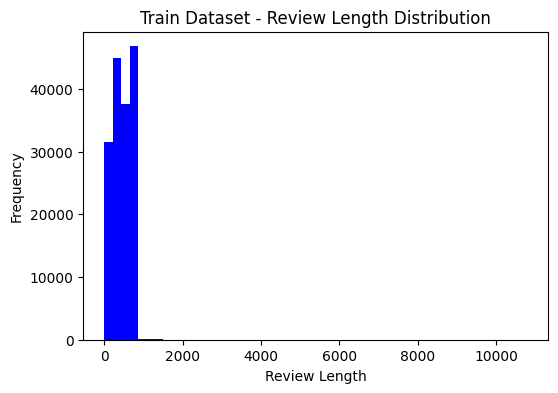

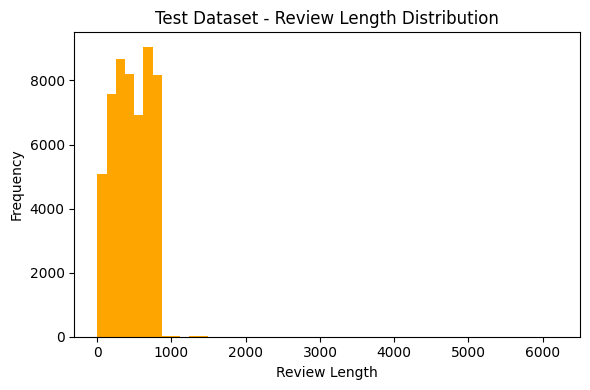

In [ ]:
# Plot the histogram of Review column for both train and test dataset.

# Firstly, compute review lengths (number of characters), change to numerical data
train_df['review_length'] = train_df['review'].astype(str).apply(len)
test_df['review_length'] = test_df['review'].astype(str).apply(len)

# Plot histogram of Review
# For Train Dataset
plt.figure(figsize=(6,4))
plt.hist(train_df['review_length'], bins = 50, color = 'blue')
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Train Dataset - Review Length Distribution")

# For Test Dataset
plt.figure(figsize=(6,4))
plt.hist(test_df['review_length'], bins = 50, color = 'orange')
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Test Dataset - Review Length Distribution")

plt.tight_layout()
plt.show()


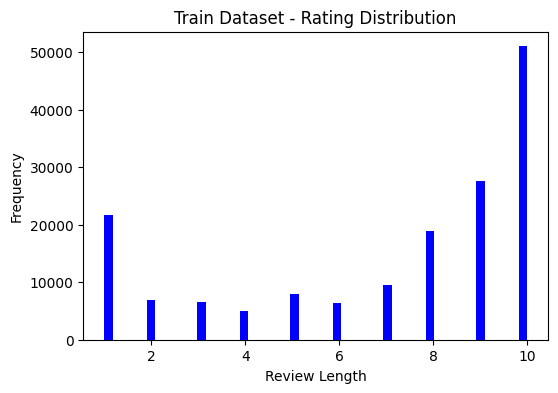

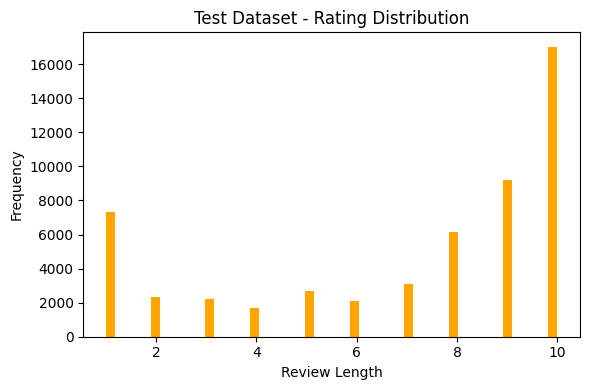

In [ ]:
# Plot histogram of Rating
# For Train Dataset
plt.figure(figsize=(6,4))
plt.hist(train_df['rating'], bins = 50, color = 'blue')
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Train Dataset - Rating Distribution")

# For Test Dataset
plt.figure(figsize=(6,4))
plt.hist(test_df['rating'], bins = 50, color = 'orange')
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Test Dataset - Rating Distribution")

plt.tight_layout()
plt.show()


In [ ]:
# Check missing value. If have missing value → delete the row have missing value.
# Missing Values in Train Dataset
print("Missing values in Train Dataset:")
print(train_df.isna().sum())

# Missing Values in Test Dataset
print("Missing values in Test Dataset:")
print(test_df.isna().sum())


Missing values in Train Dataset:
review           0
rating           0
review_length    0
dtype: int64
Missing values in Test Dataset:
review           0
rating           0
review_length    0
dtype: int64


In [ ]:
# - Create new column named “Sentiment” which based on the rating. The rule is: 1-4: Negative, 5-7: Neutral, 8-10: Positive

# Firstly, define a function to classify sentiment based on rating
def sentiment(rating):
  if rating >= 1 and rating <= 4:
    return 'Negative'
  elif rating >= 5 and rating <=6:
    return 'Neutral'
  elif rating >= 7 and rating <= 10:
    return 'Positive'

# Apply the function to the 'rating' column to create a new 'Sentiment' column
train_df['Sentiment'] = train_df['rating'].apply(sentiment)
test_df['Sentiment'] = test_df['rating'].apply(sentiment)

print("Train Dataset:")
print(train_df[['rating', 'Sentiment']].head())

print("Test_Dataset:")
print(test_df[['rating', 'Sentiment']].head())

Train Dataset:
        rating Sentiment
206461     9.0  Positive
95260      8.0  Positive
92703      5.0   Neutral
138000     8.0  Positive
35696      9.0  Positive
Test_Dataset:
        rating Sentiment
163740    10.0  Positive
206473     8.0  Positive
159672     9.0  Positive
39293      9.0  Positive
97768      9.0  Positive


In [ ]:
test_df

,review,rating,review_length,Sentiment
163740,"""I&#039;ve tried a few antidepressants over th...",10.0,439,Positive
206473,"""My son has Crohn&#039;s disease and has done ...",8.0,268,Positive
159672,"""Quick reduction of symptoms""",9.0,29,Positive
39293,"""Contrave combines drugs that were used for al...",9.0,782,Positive
97768,"""I have been on this birth control for one cyc...",9.0,762,Positive
...,...,...,...,...
159999,"""I have taken Tamoxifen for 5 years. Side effe...",10.0,533,Positive
140714,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,763,Positive
130945,"""I&#039;m married, 34 years old and I have no ...",8.0,780,Positive
47656,"""I was prescribed Nucynta for severe neck/shou...",1.0,200,Negative


### Evaluate the model performance with the test dataset

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.5.4: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
import re

def input_prompt(input_text, type="few_shot"):
  if type == "few_shot":
    prompt = f"""[INST]
You are an expert in analyzing sentiment from drug reviews. Your task is to classify a given drug review as **Positive, Negative, or Neutral** based on the user's experience.

### **Criteria for Sentiment Classification:**
- **Positive**: The review expresses satisfaction with the drug, mentioning effectiveness, relief from symptoms, or minimal side effects.
- **Negative**: The review expresses dissatisfaction, describing strong side effects, lack of effectiveness, or worsening of the condition.
- **Neutral**: The review is mixed or inconclusive, mentioning both pros and cons without strong emotions, or if the experience is unclear.

### **Only return one of the following labels: Positive, Negative, or Neutral. Do not provide explanations.

### **Examples:**

#### **Example 1:**
**Review:** "This medication completely stopped my migraines within a week. I haven't had a single headache since!"
**Sentiment:** Positive

#### **Example 2:**
**Review:** "I had high hopes, but this drug didn’t help my pain at all. On top of that, I had severe nausea."
**Sentiment:** Negative

#### **Example 3:**
**Review:** "The drug helped somewhat with my anxiety, but I still experience occasional panic attacks. No major side effects so far."
**Sentiment:** Neutral

---

### **Now classify the following review:**
**Review:** "{input_text}"
**Sentiment:**
[/INST]"""
  else:
    prompt = f"""[INST]
You are an expert in analyzing sentiment from drug reviews. Your task is to classify a given drug review as **Positive, Negative, or Neutral** based on the user's experience.

### **Criteria for Sentiment Classification:**
- **Positive**: The review expresses satisfaction with the drug, mentioning effectiveness, relief from symptoms, or minimal side effects.
- **Negative**: The review expresses dissatisfaction, describing strong side effects, lack of effectiveness, or worsening of the condition.
- **Neutral**: The review is mixed or inconclusive, mentioning both pros and cons without strong emotions, or if the experience is unclear.

### **Only return one of the following labels: Positive, Negative, or Neutral. Do not provide explanations.**

---

### **Classify the sentiment of the following review:**
**Review:** "{input_text}"
**Sentiment:**
[/INST]"""
  return prompt

def inference_model(input_text, model, tokenizer, type="few_shot", temperature=0.5):
  prompt = input_prompt(input_text, type=type)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
  model_inputs = encodeds.to(device)

  generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=False, temperature=temperature)

  decoded = tokenizer.batch_decode(generated_ids,skip_special_tokens=True)
  # print(decoded[0])

  # Get the output only instead of whole prompt
  match = re.search(r'\*\*Sentiment:\*\*\s*(\w+)', decoded[0][len(prompt)-40:])
  return match.group(1) if match else None

In [ ]:
input_text = 'This drug is pretty amazing. I&#039;ve had hyperhydrosis of the palms, soles and underarms since hitting puberty. I was skeptic since I&#039;ve previously tried botox, iontophoresis and drysol with limited results. However, after three days of taking oxybutynin (5mg 3x a day) I was 95% sweat-free. My only negative things to say about the drug is about side effects. I have gotten fairly dizzy/spaced out a few times, and I experience dry mouth pretty often. However, that&#039;s not bad in comparison to the acne I&#039;ve gotten. I used to get pimples around once a month, however now I have ones lasting for &lt;6 wks, varying in size/colour. I constantly have groups of acne on my face. Does anyone have any remedies? I&#039;ve tried acne masks, cleansers and tea tree oil.'
predict_sentiment = inference_model(input_text = input_text, model = model, tokenizer=tokenizer)
print(predict_sentiment)

Positive


In [ ]:
# Process each row
def run_experiment(test_df, type='few_shot', temperature=0.5):
  test_df = test_df.copy()
  test_df['Predict_sentiment'] = None

  save_path = f"/content/drive/MyDrive/shin_colab/{type}_prompt_{temperature}.csv"

  latencies = []  # Store inference times
  start_time = time.time()  # Start tracking total processing time
  process = psutil.Process()  # Track memory usage
  total_samples = 0  # Track number of processed reviews

  for index, row in tqdm(test_df.iloc[:500].iterrows(), total=500):
      if pd.isna(row['Predict_sentiment']):  # Process only if not already done
          input_text = test_df.at[index, "review"]

          # Measure inference latency
          inference_start = time.time()
          test_df.at[index, 'Predict_sentiment'] = inference_model(input_text=input_text, model=model, tokenizer=tokenizer,
                                                                   type=type, temperature=temperature)
          inference_end = time.time()

          # Compute latency and store it
          latency = inference_end - inference_start
          latencies.append(latency)

          GT = test_df.at[index, 'Sentiment']
          # print(f"Review number {index}: {input_text} have GT {GT} and predict {test_df.at[index, 'Predict_sentiment']}")
          # Save after processing each row
          test_df.to_csv(save_path, index=False)
          # print(f"Row {index} processed and saved.")

          # Increment processed sample count
          total_samples += 1



  total_time = time.time() - start_time
  avg_latency = sum(latencies) / len(latencies)
  throughput = len(latencies) / total_time  # Reviews per second
  memory_usage = process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB

  new_test_df = pd.read_csv(save_path)

  # Select the first 500 rows
  new_test_df_copy = new_test_df.iloc[:500].copy()  # Use .copy() to avoid SettingWithCopyWarning


  y_pred = list(new_test_df_copy['Predict_sentiment'])
  y_true = list(new_test_df_copy['Sentiment'])


  # Compute classification metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')

  print("\n=== Model Performance Metrics ===")
  print(f"Accuracy: {accuracy:.2f}")
  print(f"Precision (Macro): {precision:.2f}")
  print(f"Recall (Macro): {recall:.2f}")
  print(f"F1-Score (Macro): {f1:.2f}")

  print(classification_report(y_true, y_pred))

  conf_matrix = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(6, 5))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels=['Negative', 'Neutral', 'Positive'],
              yticklabels=['Negative', 'Neutral', 'Positive'])
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

  # Print performance results
  print("\n=== Runtime Performance Metrics ===")
  print(f"Total samples processed: {total_samples}")
  print(f"Total Inference Time: {total_time:.2f} sec")
  print(f"Average Latency per Review: {avg_latency:.4f} sec")
  print(f"Throughput: {throughput:.2f} reviews/sec")
  print(f"Memory Usage (RSS): {memory_usage:.2f} MB")





100%|██████████| 500/500 [13:27<00:00,  1.62s/it]



=== Model Performance Metrics ===
Accuracy: 0.74
Precision (Macro): 0.58
Recall (Macro): 0.61
F1-Score (Macro): 0.58
              precision    recall  f1-score   support

    Negative       0.60      0.95      0.74       140
     Neutral       0.15      0.16      0.16        43
    Positive       0.98      0.73      0.83       317

    accuracy                           0.74       500
   macro avg       0.58      0.61      0.58       500
weighted avg       0.81      0.74      0.75       500



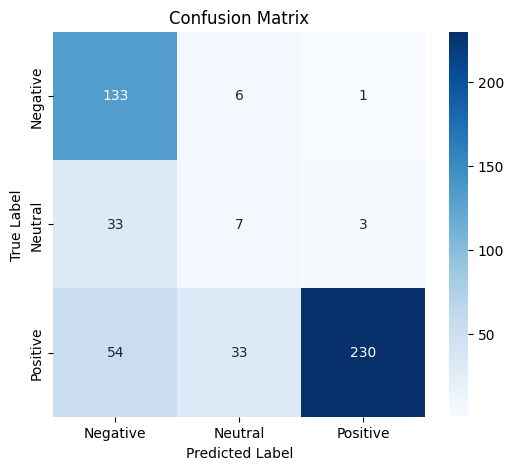


=== Runtime Performance Metrics ===
Total samples processed: 500
Total Inference Time: 807.99 sec
Average Latency per Review: 0.5734 sec
Throughput: 0.62 reviews/sec
Memory Usage (RSS): 2167.14 MB


In [ ]:
run_experiment(test_df, type='zero_shot')

100%|██████████| 500/500 [13:44<00:00,  1.65s/it]



=== Model Performance Metrics ===
Accuracy: 0.75
Precision (Macro): 0.58
Recall (Macro): 0.62
F1-Score (Macro): 0.59
              precision    recall  f1-score   support

    Negative       0.63      0.94      0.75       140
     Neutral       0.16      0.16      0.16        43
    Positive       0.97      0.75      0.84       317

    accuracy                           0.75       500
   macro avg       0.58      0.62      0.59       500
weighted avg       0.80      0.75      0.76       500



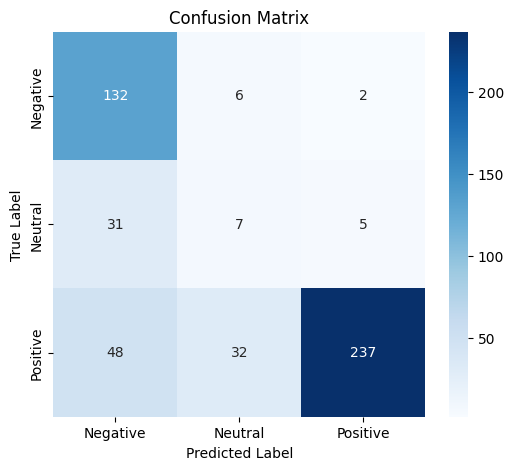


=== Runtime Performance Metrics ===
Total samples processed: 500
Total Inference Time: 824.04 sec
Average Latency per Review: 0.6698 sec
Throughput: 0.61 reviews/sec
Memory Usage (RSS): 2204.87 MB


In [ ]:
run_experiment(test_df, type='few_shot')

100%|██████████| 500/500 [13:48<00:00,  1.66s/it]



=== Model Performance Metrics ===
Accuracy: 0.75
Precision (Macro): 0.58
Recall (Macro): 0.62
F1-Score (Macro): 0.59
              precision    recall  f1-score   support

    Negative       0.63      0.94      0.75       140
     Neutral       0.16      0.16      0.16        43
    Positive       0.97      0.75      0.84       317

    accuracy                           0.75       500
   macro avg       0.58      0.62      0.59       500
weighted avg       0.80      0.75      0.76       500



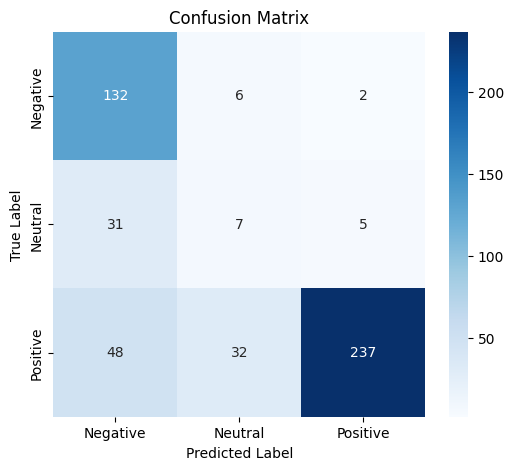


=== Runtime Performance Metrics ===
Total samples processed: 500
Total Inference Time: 828.05 sec
Average Latency per Review: 0.6697 sec
Throughput: 0.60 reviews/sec
Memory Usage (RSS): 2191.40 MB


In [ ]:
run_experiment(test_df, type='few_shot', temperature=0.7)